In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr 

import src.ts as ts

# Данные

Дивиденды реинвестирую на следующий день после ex-dividend даты.

Доходность 10-летних гос. облигаций США скачал отсюда: https://www.investing.com/rates-bonds/u.s.-10-year-bond-yield-historical-data

In [3]:
df = pd.read_json("./data/task1/VFINX.json")
df["VFINX"] = df["Close"] + df["Dividends"].cumsum().shift().fillna(0)

rf = pd.read_csv("./data/rf.csv", 
                 index_col="Date", 
                 parse_dates=True,).loc[:, "Price"]
rf = (1 + rf) ** (1 / 365) - 1

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close,VFINX
1986-01-02,9.969467,9.969467,9.969467,9.969467,0,0.0,0,18.07,9.969467
1986-01-03,10.035052,10.035052,10.035052,10.035052,0,0.0,0,17.96,10.035052
1986-01-06,10.030688,10.030688,10.030688,10.030688,0,0.0,0,17.05,10.030688
1986-01-07,10.179354,10.179354,10.179354,10.179354,0,0.0,0,17.39,10.179354
1986-01-08,9.899508,9.899508,9.899508,9.899508,0,0.0,0,19.97,9.899508


# Задание

Построить торговлю индексом `VFINX`, удовлетворяющую условиям: 
$$SR \rightarrow max,  \\ s.t.SR \ge 0.6, CAGR \sim 10.9\%$$

# EDA

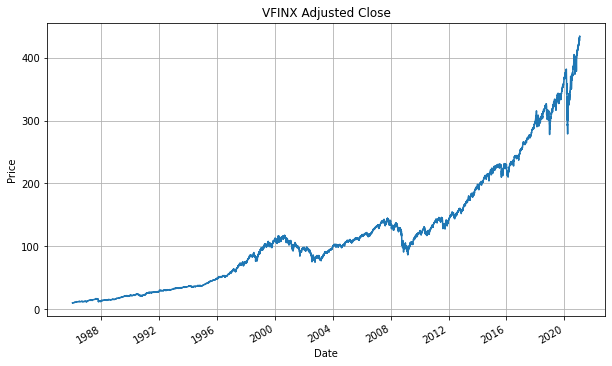

In [4]:
df["VFINX"].plot(
    figsize=(10, 6), 
    title="VFINX Adjusted Close", 
    xlabel="Date",
    ylabel="Price",
    grid=True,
);

Видно, что из-за большого периода плохо различима динамика индекса в первые годы. Визуально кажется, что в последнее время волатильность сильно возросла, хотя это не совсем так. Имеет смысл для сравнения со стратегией смотреть на лог-график накопленной доходности.

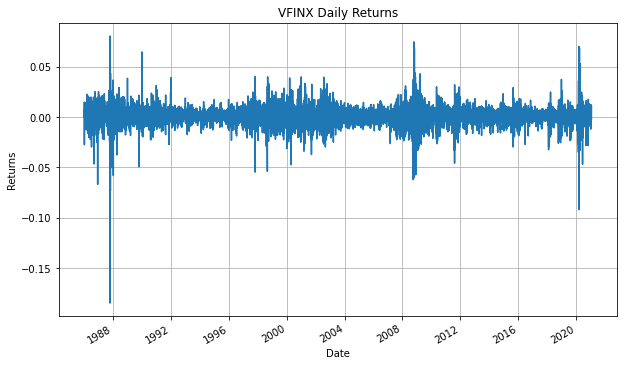

In [5]:
df["VFINX"].pct_change().plot(
    figsize=(10, 6), 
    title="VFINX Daily Returns", 
    xlabel="Date",
    ylabel="Returns",
    grid=True,
);

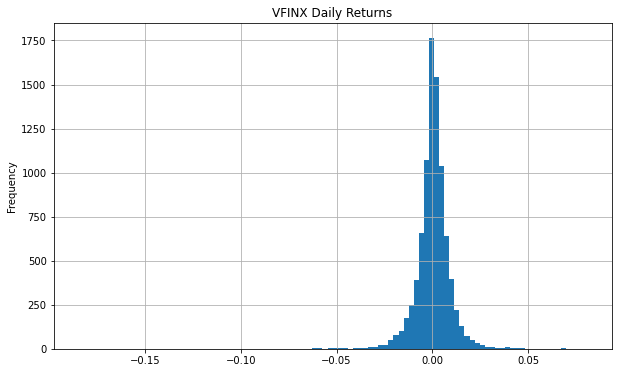

In [6]:
df["VFINX"].pct_change().plot.hist(
    bins=100,
    figsize=(10, 6), 
    title="VFINX Daily Returns", 
    grid=True,
);

Дневная доходность фонда `VFINX` в основном колеблется в районе +/-2-3%, но наблюдаются и периоды, когда доходность резко выстреливает как вниз так и вверх. При этом по модулю наибольший спайк вниз произошел в конце 1980-х. 

Распределение доходности в целом похоже на нормальное (возможно, лог-нормальное) со средним в нуле, но имеются "тяжелые хвосты", причем левый хвост (отрицательная доходность) "тяжелее" правого.

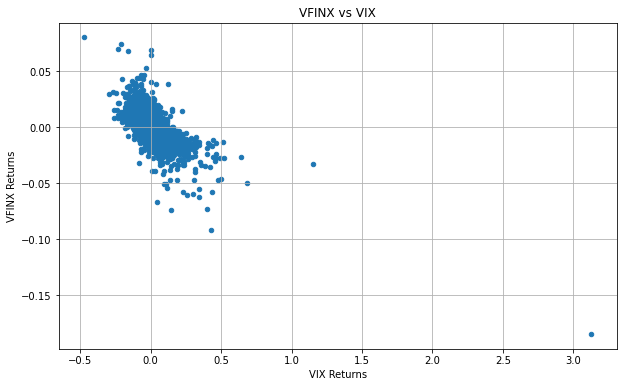

In [7]:
df[["VFINX", "VIX_Close"]].pct_change().plot.scatter(
    x="VIX_Close",
    y="VFINX",
    title="VFINX vs VIX",
    xlabel="VIX Returns",
    ylabel="VFINX Returns",
    grid=True,
    figsize=(10, 6),
);

Заметно, что есть отрицательная взаимосвязь между доходностью `VFINX` и процентными изменениями индекса `VIX`. Что неудивительно, т.к. `VIX` по сути показывает волатильность индекса, а рост волатильности обычно происходит в периоды шоков на рынке.

# Скейлинг относительно VIX

Попробуем классический подход - скейлинг по волатильности:
$$w = \frac{VIX_{target}}{VIX_{forecast}}$$

$VIX_{target}$ в идеале надо выбирать на основе какого-то фундаментального исследования, но в задании запрещено пользоваться другими данными, поэтому просто осуществим перебор.

$VIX_{forecast}$ можно тоже делать на основе фундаментальных данных, но для простоты будем брать среднее за последние $n$ периодов, кол-во периодов тоже просто переберем.

In [8]:
targets = [
    1,
    3,
    5,
    9,
    11,
    17,
    20,
    25,
    30,
]

ns = [
    1,
    3,
    5,
    7,
    9,
    11,
    13,
    17,
    20,
    33,
]

In [9]:
ts.grid_search(
    targets=targets,
    ns=ns,
    df=df,
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf,
    )
).style.background_gradient(cmap="Greens").format(precision=4)

target,1,3,5,9,11,17,20,25,30
n,,,,,,,,,
1,-4.2121,-0.7731,-0.0772,0.3872,0.4899,0.6019,0.6124,0.6012,0.5998
3,-4.1748,-0.7666,-0.0771,0.3829,0.4850,0.5996,0.6085,0.5948,0.6028
5,-4.1388,-0.7494,-0.0640,0.3934,0.4952,0.6153,0.6212,0.6048,0.6133
7,-4.1050,-0.7362,-0.0551,0.3995,0.5008,0.6191,0.6225,0.6068,0.6114
9,-4.0757,-0.7262,-0.0490,0.4029,0.5032,0.6197,0.6218,0.6055,0.6075
11,-4.0523,-0.7214,-0.0481,0.4012,0.5006,0.6143,0.6166,0.6040,0.6030
13,-4.0337,-0.7179,-0.0477,0.3994,0.4984,0.6120,0.6128,0.6029,0.6032
17,-4.0049,-0.7180,-0.0538,0.3894,0.4878,0.5978,0.5973,0.5931,0.5957
20,-3.9907,-0.7228,-0.0624,0.3782,0.4762,0.5861,0.5853,0.5866,0.5918


In [10]:
(ts.grid_search(
    targets=targets,
    ns=ns,
    df=df,
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    )
) * 100).style.background_gradient(cmap="Greens").format(precision=2)

target,1,3,5,9,11,17,20,25,30
n,,,,,,,,,
1,0.61,1.82,3.03,5.45,6.63,9.24,9.97,10.52,10.88
3,0.61,1.82,3.03,5.45,6.64,9.29,10.01,10.52,10.98
5,0.62,1.85,3.08,5.53,6.74,9.49,10.21,10.71,11.15
7,0.62,1.86,3.10,5.58,6.80,9.57,10.26,10.77,11.15
9,0.63,1.87,3.12,5.61,6.84,9.61,10.29,10.78,11.12
11,0.63,1.88,3.12,5.62,6.84,9.59,10.26,10.79,11.08
13,0.63,1.88,3.12,5.62,6.83,9.59,10.24,10.80,11.10
17,0.62,1.86,3.10,5.57,6.78,9.48,10.09,10.71,11.04
20,0.61,1.84,3.07,5.51,6.71,9.38,9.98,10.65,11.01


Простой подход дал необходимый результат. Максимальный $SR$ (0.6225) достигается при комбинации параметров $n=7, VIX_{target} = 20$, при этом $CAGR$ равен 10.26%. Возьмем такую стратегию как основную.

In [11]:
portfolio = pqr.Portfolio.backtest(
    longs=df[["VFINX"]].astype(bool),
    shorts=None,
    allocator=pqr.utils.compose(
        lambda holdings: holdings.astype(float),
        pqr.utils.partial(
            ts.vix_scaling,
            vix=df["VIX_Close"],
            n=7,
            target=20,
        ),
    ),
    calculator=pqr.utils.partial(
        pqr.calculate_returns,
        universe_returns=pqr.prices_to_returns(df[["VFINX"]]),
    ),
    name="VIX Scaling",
)

# Оценка устойчивости и работоспособности системы

,VIX Scaling
Sharpe Ratio,0.62
"CAGR, %",10.26


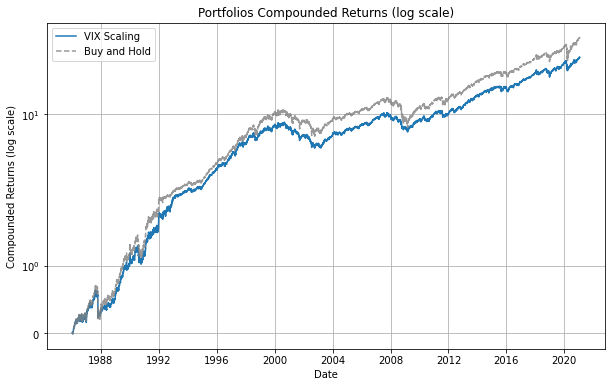

In [12]:
benchmark = pqr.Benchmark.from_index(
    index=df["VFINX"], 
    name="Buy and Hold",
)

table = pqr.metrics.Table()
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf,
    ),
    name="Sharpe Ratio",
)
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    ),
    multiplier=100,
    name="CAGR, %",
)

fig = pqr.metrics.Figure(
    metric=pqr.metrics.compounded_returns,
    name="Compounded Returns (log scale)",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    },
)

summary = pqr.metrics.Dashboard([table, fig])

summary.display([portfolio])

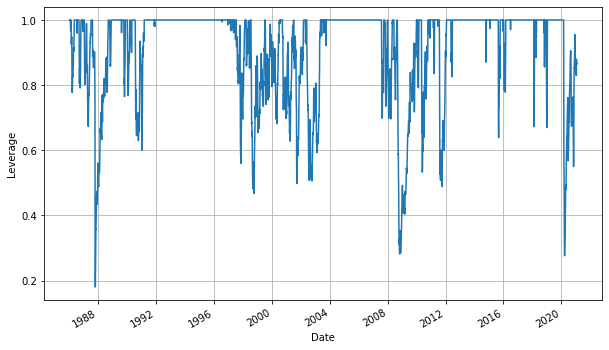

In [13]:
portfolio.holdings["VFINX"].plot(
    figsize=(10, 6),
    xlabel="Date",
    ylabel="Leverage",
    grid=True,
);

Видно, что большую часть времени стратегия сидит на 100% в индексе, а снижение веса обычно носит очень резкий, но временный характер, при этом в основном это снижение происходит в периоды кризисов (конец 1980-х-1990-е, начало 2000-х, 2008 и 2020 годы).

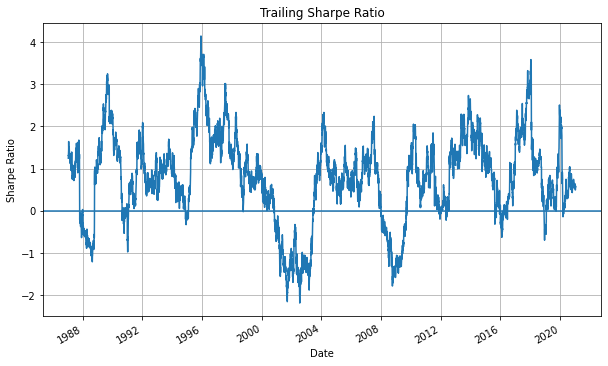

In [14]:
pqr.metrics.trailing_sharpe_ratio(
    portfolio,
    rf=rf,
    window=252,
    annualizer=252,
).plot(
    figsize=(10, 6),
    title="Trailing Sharpe Ratio",
    xlabel="Date",
    ylabel="Sharpe Ratio",
    grid=True,
)
plt.axhline(0);

Скользящий Шарп по году довольно волатилен, но чаще положительный, чем отрицательный. Резкие падения происходят только в периоды кризисов, плавные снижения редко приводят к падению ниже 0.

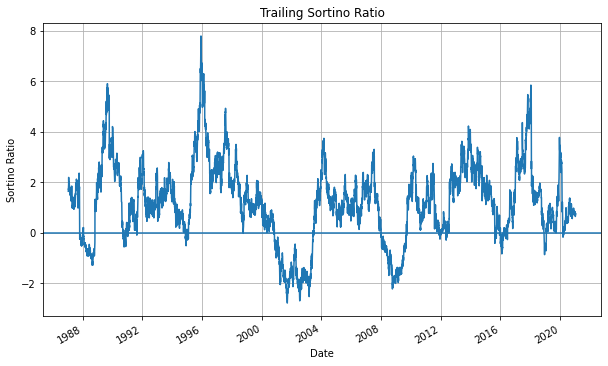

In [15]:
pqr.metrics.trailing_sortino_ratio(
    portfolio,
    rf=rf,
    window=252,
    annualizer=252,
).plot(
    figsize=(10, 6),
    title="Trailing Sortino Ratio",
    xlabel="Date",
    ylabel="Sortino Ratio",
    grid=True,
)
plt.axhline(0);

С точки зрения Сортино картина очень похожа на Шарп, т.е. рассмотрения как риска только просадки вниз не вносит значимых изменений в оценку стратегии.

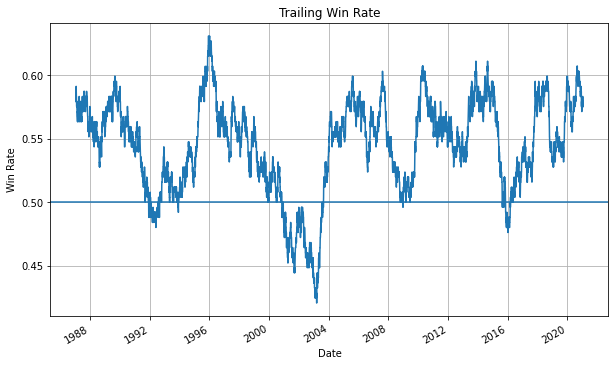

In [16]:
pqr.metrics.trailing_win_rate(
    portfolio,
    window=252,
).plot(
    figsize=(10, 6),
    title="Trailing Win Rate",
    xlabel="Date",
    ylabel="Win Rate",
    grid=True,
)
plt.axhline(0.5);

В основном в течение года дней с положительной доходностью больше половины (за исключение периода с 2000 по 2004 года), что говорит об устойчивости стратегии.

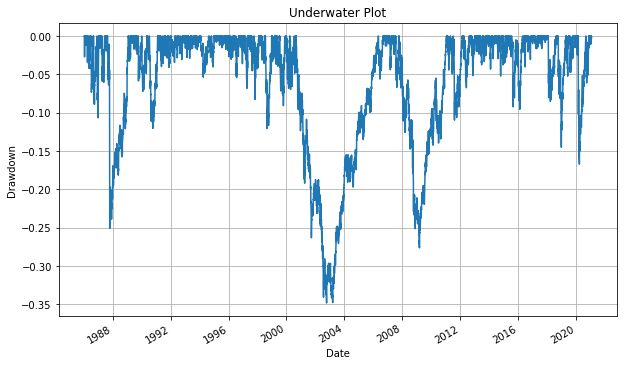

In [17]:
pqr.metrics.drawdown(
    portfolio,
).plot(
    figsize=(10, 6),
    title="Underwater Plot",
    xlabel="Date",
    ylabel="Drawdown",
    grid=True,
);

Просадки в целом невысокие и недлительные, но наиболее серьезные достигали от 25% до 35%, что уже довольно рискованно. Однако после крупных просадок восстановление было достаточно быстрым, к тому же в 2020 году просадка составила всего 15%, в то время как S&P500 в то же время терял до 30%.

In [18]:
print(
    f"Daily VaR = {pqr.metrics.value_at_risk(portfolio, cutoff=0.05, annualizer=1) * 100:.3f}%\n"
    f"Daily ETL = {pqr.metrics.expected_tail_loss(portfolio, cutoff=0.05, annualizer=1) * 100:.3f}%"
)

Daily VaR = -1.095%
Daily ETL = -1.628%


Дневные потери с вероятностью 95% не превышают 1-1.5%, что также говорит об устойчивости стратегии.

В целом стратегия получилась довольно работоспособной и стабильной: несмотря на неудачный период 2000-2004 гг. в остальное время эффективность стратегии была на довольно высоком уровне и имела хорошее соотношение риска и прибыли с точки зрения коэффициента Шарпа, при этом не теряя очень много в доходности относительно `Buy&Hold` стратегии.